This notebook is meant to be run in google colab. You can find import your local copy of the file in the the [colab welcome page](https://colab.research.google.com/).

# Setting up your declearn 

We first clone the repo, to have both the package itself and the `examples` folder we will use in this tutorial, then naviguate to the package directory, and finally install the required dependencies.

**If you have already cloned the repository and/or installed declearn, you may skip the following commands.** Simply make sure to set your current working directory to the folder under which the `examples/mnist_quickrun` subfolder may be found (as cloned or downloaded from the repo).

In [ ]:
# you may want to specify a release branch or tag
!git clone https://gitlab.inria.fr/magnet/declearn/declearn2

In [ ]:
cd declearn2

In [ ]:
# Install the package, with TensorFlow and Websockets extra dependencies.
# You may want to work in a dedicated virtual environment.
!pip install .[tensorflow,websockets]

# Running your first experiment

We are going to train a common model between three simulated clients on the classic [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The input of the model is a set of images of handwritten digits, and the model needs to determine which number between 0 and 9 each image corresponds to.

## The model

To do this, we will use a simple CNN, defined in `examples/mnist_quickrun/model.py`.

Here, the model is implemented in TensorFlow, which is merely an implementation detail. If you update the `config.toml` file to use the `examples/mnist_quickrun/model_torch.py`, you will train a model with the same architecture, but implemented with Torch.

In [ ]:
from examples.mnist_quickrun.model import network

network.summary()  # network is a `tensorflow.keras.Model` instance

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 dense (Dense)               (None, 64)                86592     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

## The data

We start by splitting the MNIST dataset between 3 clients and storing the output in the `examples/mnist_quickrun` folder. For this we use an experimental utility provided by `declearn`. 

In [ ]:
from declearn.dataset import split_data

split_data(folder="examples/mnist_quickrun")

Splitting data into 3 shards using the 'iid' scheme.


The python code above is equivalent to running `declearn-split examples/mnist_quickrun/` in a shell command-line.

Here is what the first image of the first client looks like:

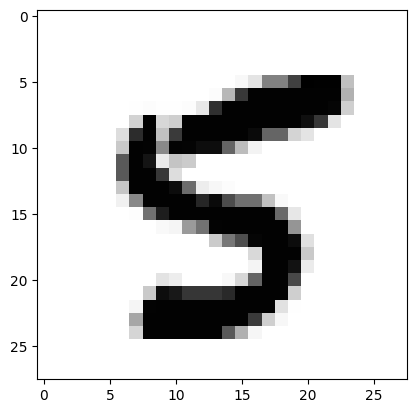

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images = np.load("examples/mnist_quickrun/data_iid/client_0/train_data.npy")
sample_img = images[0]
sample_fig = plt.imshow(sample_img,cmap='Greys')


For more information on how the `split_data` function works, you can look at the documentation. 

In [ ]:
print(split_data.__doc__)

Randomly split a dataset into shards.

    The resulting folder structure is :
        folder/
        └─── data*/
            └─── client*/
            │      train_data.* - training data
            │      train_target.* - training labels
            │      valid_data.* - validation data
            │      valid_target.* - validation labels
            └─── client*/
            │    ...

    Parameters
    ----------
    folder: str, default = "."
        Path to the folder where to add a data folder
        holding output shard-wise files
    data_file: str or None, default=None
        Optional path to a folder where to find the data.
        If None, default to the MNIST example.
    target_file: str or int or None, default=None
        If str, path to the labels file to import, or name of a `data`
        column to use as labels (only if `data` points to a csv file).
        If int, index of a `data` column of to use as labels).
        Required if data is not None, ignored if da

## Quickrun

We can now run our experiment. As explained in the section 2.1 of the [quickstart documentation](https://magnet.gitlabpages.inria.fr/declearn/docs/latest/quickstart), using the `declearn-quickrun` entry-point requires a configuration file, some data, and a model:

* A TOML file, to store your experiment configurations. Here: 
`examples/mnist_quickrun/config.toml`.
* A folder with your data, split by client. Here: `examples/mnist_quickrun/data_iid`
* A model python file, to declare your model wrapped in a `declearn` object. Here: `examples/mnist_quickrun/model.py`.

We then only have to run the `quickrun` coroutine with the path to the TOML file:

In [ ]:
from declearn.quickrun import quickrun

await quickrun(config="examples/mnist_quickrun/config.toml")

The python code above is equivalent to running `declearn-quickrun examples/mnist_quickrun/config.toml` in a shell command-line.

The output obtained is the combination of the CLI output of our server and our clients, going through: 

* `INFO:Server:Starting clients registration process.` : a first registration step, where clients register with the server
* `INFO:Server:Sending initialization requests to clients.`: the initilization of the object needed for training on both the server and clients side.
* `Server:INFO: Initiating training round 1`: the training starts, where each client makes its local update(s) and send the result to the server which aggregates them
* `INFO: Initiating evaluation round 1`: the model is evaluated at each round
* `Server:INFO: Stopping training`: the training is finalized  

## Results 

You can have a look at the results in the `examples/mnist_quickrun/result_*` folder, including the metrics evolution during training. 

In [ ]:
import pandas as pd
import glob
import os 

res_file = glob.glob('examples/mnist_quickrun/result*') 
res = pd.read_csv(os.path.join(res_file[0],'server/metrics.csv'))
res_fig = res.plot()

# Experiment further


You can change the TOML config file to experiment with different strategies.

For instance, try splitting the data in a very heterogenous way, by distributing digits in mutually exclusive way between clients. 

In [ ]:
split_data(folder="examples/mnist_quickrun",scheme='labels')

And change the `examples/mnist_quickrun/config.toml` file with:

```
[data] 
    data_folder = "examples/mnist_quickrun/data_labels" 
```

If you run the model as is, you should see a drop of performance



In [ ]:
quickrun(config="examples/mnist_quickrun/config.toml")

Now try modifying the `examples/mnist_quickrun/config.toml` file like this, to implement the [scaffold algorithm](https://arxiv.org/abs/1910.06378) and running the experiment again. 

```
  [optim]

      [optim.client_opt]
      lrate = 0.005 
      modules = ["scaffold-client"] 

      [optim.server_opt]
      lrate = 1.0 
      modules = ["scaffold-client"]
```

In [ ]:
quickrun(config="examples/mnist_quickrun/config.toml")